In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [2]:
params_dict_mu = {
    'input_size': 3,
    'hidden_size': 10,
    'output_size': 3,
    'ode_nn': ((50, "tanh"), (50, "tanh")),
    'readout_nn': ((50, "tanh"), (50, "tanh")),
    'enc_nn': ((50, "tanh"), (50, "tanh")),
    'use_rnn': False,
    'options': {'which_loss': 'easy'},
    "input_coords": np.arange(3),
    "output_coords": np.arange(3)
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from models_1 import get_ckpt_model, NJODE
model_mu = NJODE(**params_dict_mu).to(device)
optimizer = torch.optim.Adam(model_mu.parameters())
get_ckpt_model("../data/saved_models/id-51/last_checkpoint/", model_mu, optimizer, device)
model_mu.eval()

using loss: easy
neuralODE use input scaling with tanh
use residual network: input_size=3, output_size=10
use residual network: input_size=10, output_size=3


NJODE(
  (ode_f): ODEFunc(
    (f): Sequential(
      (0): Linear(in_features=15, out_features=50, bias=True)
      (1): Tanh()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
      (4): Tanh()
      (5): Dropout(p=0, inplace=False)
      (6): Linear(in_features=50, out_features=10, bias=True)
    )
  )
  (encoder_map): FFNN(
    (ffnn): Sequential(
      (0): Linear(in_features=3, out_features=50, bias=True)
      (1): Tanh()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
      (4): Tanh()
      (5): Dropout(p=0, inplace=False)
      (6): Linear(in_features=50, out_features=10, bias=True)
    )
  )
  (readout_map): FFNN(
    (ffnn): Sequential(
      (0): Linear(in_features=10, out_features=50, bias=True)
      (1): Tanh()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
      (4): Tanh()
      (5): Dropout(p=0, inplace=False)
 

In [3]:
params_dict_vol = {
    'input_size': 9,
    'hidden_size': 10,
    'output_size': 9,
    'ode_nn': ((50, "tanh"), (50, "tanh")),
    'readout_nn': ((50, "tanh"), (50, "tanh")),
    'enc_nn': ((50, "tanh"), (50, "tanh")),
    'use_rnn': False,
    'options': {'which_loss': 'easy_vol'},
    "input_coords": np.arange(9),
    "output_coords": np.arange(9)
}
model_vol = NJODE(**params_dict_vol).to(device)
optimizer_vol = torch.optim.Adam(model_vol.parameters())
get_ckpt_model("../data/saved_models/id-52/last_checkpoint/", model_vol, optimizer_vol, device)
model_vol.eval()

using loss: easy_vol
neuralODE use input scaling with tanh
use residual network: input_size=9, output_size=10
use residual network: input_size=10, output_size=9


NJODE(
  (ode_f): ODEFunc(
    (f): Sequential(
      (0): Linear(in_features=21, out_features=50, bias=True)
      (1): Tanh()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
      (4): Tanh()
      (5): Dropout(p=0, inplace=False)
      (6): Linear(in_features=50, out_features=10, bias=True)
    )
  )
  (encoder_map): FFNN(
    (ffnn): Sequential(
      (0): Linear(in_features=9, out_features=50, bias=True)
      (1): Tanh()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
      (4): Tanh()
      (5): Dropout(p=0, inplace=False)
      (6): Linear(in_features=50, out_features=10, bias=True)
    )
  )
  (readout_map): FFNN(
    (ffnn): Sequential(
      (0): Linear(in_features=10, out_features=50, bias=True)
      (1): Tanh()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
      (4): Tanh()
      (5): Dropout(p=0, inplace=False)
 

In [4]:
mu_data=np.load("../data/training_data/OrnsteinUhlenbeckMultiDimensional-46/data.npy")

In [5]:
vol_data=np.load("../data/training_data/OrnsteinUhlenbeckForZ-45/data.npy")

In [6]:
 def generate_next_value( X_t, mu_t, sigma_t, delta_t):
    """
    Generate the next value in the time series using the Euler-Maruyama scheme.

    :param X_t: current value tensor of shape (batch_size, d)
    :param mu_t: drift coefficient tensor of shape (batch_size, d)
    :param sigma_t: diffusion coefficient tensor of shape ( d, d)
    :param delta_t: time difference float
    :return: next value tensor of shape (batch_size, d)
    """
    delta_Wt = torch.randn_like(X_t) * delta_t** 0.5

    X_t_next = X_t + mu_t * delta_t + delta_Wt @ sigma_t

    return X_t_next

In [21]:
times=np.array([0.01,])
time_ptr = np.array([0, 1])
obs_idx = torch.tensor([0],dtype=torch.long)
Vol = torch.tensor([],dtype=torch.float)
delta_t=0.01
T=1
X= torch.tensor(mu_data[0,:,0], dtype=torch.float).unsqueeze(0)
start_X = torch.tensor(mu_data[0,:,0], dtype=torch.float).unsqueeze(0)
n_obs_ot=torch.tensor([1], dtype=torch.float) 

for i in range(2,102):
    times=np.append(times, 0.01*i)
    time_ptr = np.append(time_ptr, i) 
    obs_idx=torch.cat((obs_idx, torch.tensor([0], dtype=torch.long)))
    n_obs_ot+=1
    X= torch.cat((X, torch.tensor(mu_data[0,:,i-1], dtype=torch.float).unsqueeze(0))) 
    print(X)
    # Here mu_pred is conditional expectation of X_t at time 0.01*(i-1) 
    mu_pred=model_mu.get_pred1(times, time_ptr, X, obs_idx, delta_t, T, start_X, n_obs_ot)["pred"][-1]
    
    X_t_plus = X[i-1,:].unsqueeze(0)
    X_t = X[i-2, :].unsqueeze(0) 
    vol_tensor = (X_t_plus - X_t).T@(X_t_plus-X_t) 
    vol  = vol_tensor.view(1,-1)
    Vol = torch.cat((Vol, vol))  
        
        
    # Here sigma_pred conditional expectation of Z_t at time 0.01*(i-2) 
    sigma_pred=model_vol.get_pred1(times[:-1], time_ptr[:-1], Vol, obs_idx[:-1], delta_t, T, vol, (n_obs_ot-1) )["pred"][-1]
    
    # Computed mu_hat and sigma_hat at time 0.01*(i-2) 
    mu_hat_t = (mu_pred - X_t)/delta_t
    sigma_hat_t = sigma_pred/(delta_t**0.5) 
    
    # generated new point at time 0.01*(i-1) 
    X_next = generate_next_value(X_t, mu_hat_t, sigma_hat_t.view(3,3), delta_t)
    print(X_next)
    # Replace the old real data at time 0.01*(i-1) with generated data 
    X[i-1,:] = X_next 
    print(X)

tensor([[1.0000, 1.5000, 2.0000],
        [1.0497, 1.5354, 2.0485]])
tensor([[1.0814, 1.5796, 2.1193]], grad_fn=<AddBackward0>)
tensor([[1.0000, 1.5000, 2.0000],
        [1.0814, 1.5796, 2.1193]], grad_fn=<CopySlices>)
tensor([[1.0000, 1.5000, 2.0000],
        [1.0814, 1.5796, 2.1193],
        [1.1038, 1.5926, 2.0575]], grad_fn=<CatBackward0>)
tensor([[1.1116, 1.5830, 2.0678]], grad_fn=<AddBackward0>)
tensor([[1.0000, 1.5000, 2.0000],
        [1.0814, 1.5796, 2.1193],
        [1.1116, 1.5830, 2.0678]], grad_fn=<CopySlices>)
tensor([[1.0000, 1.5000, 2.0000],
        [1.0814, 1.5796, 2.1193],
        [1.1116, 1.5830, 2.0678],
        [1.1206, 1.5949, 2.0596]], grad_fn=<CatBackward0>)
tensor([[1.1115, 1.5752, 2.0388]], grad_fn=<AddBackward0>)
tensor([[1.0000, 1.5000, 2.0000],
        [1.0814, 1.5796, 2.1193],
        [1.1116, 1.5830, 2.0678],
        [1.1115, 1.5752, 2.0388]], grad_fn=<CopySlices>)
tensor([[1.0000, 1.5000, 2.0000],
        [1.0814, 1.5796, 2.1193],
        [1.1116, 1.5830

In [20]:
mu_data[0,:,:10].T

array([[1.        , 1.5       , 2.        ],
       [1.04967   , 1.53543183, 2.04850424],
       [1.10384165, 1.59261521, 2.05752789],
       [1.12058614, 1.59492951, 2.059631  ],
       [1.14501952, 1.61479961, 2.10600747],
       [1.1660606 , 1.62743129, 2.12512045],
       [1.18572511, 1.6635587 , 2.13411764],
       [1.15795843, 1.61715285, 2.04894708],
       [1.17237964, 1.63540968, 2.03911794],
       [1.20377152, 1.61966403, 2.04594899]])

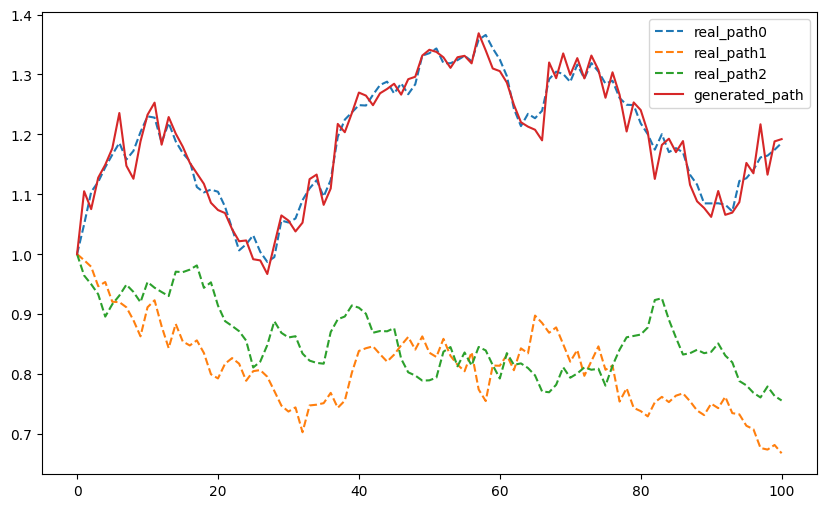

In [9]:
real_path =  mu_data[:,0,:].T
generated_path = X[:,0] 

plt.figure(figsize=(10, 6))
for i in range(3):
    plt.plot(real_path[:,i], label=f'real_path{i}', linestyle="--")

plt.plot(generated_path.unsqueeze(1).detach().numpy(), label='generated_path')
plt.legend()
plt.show()

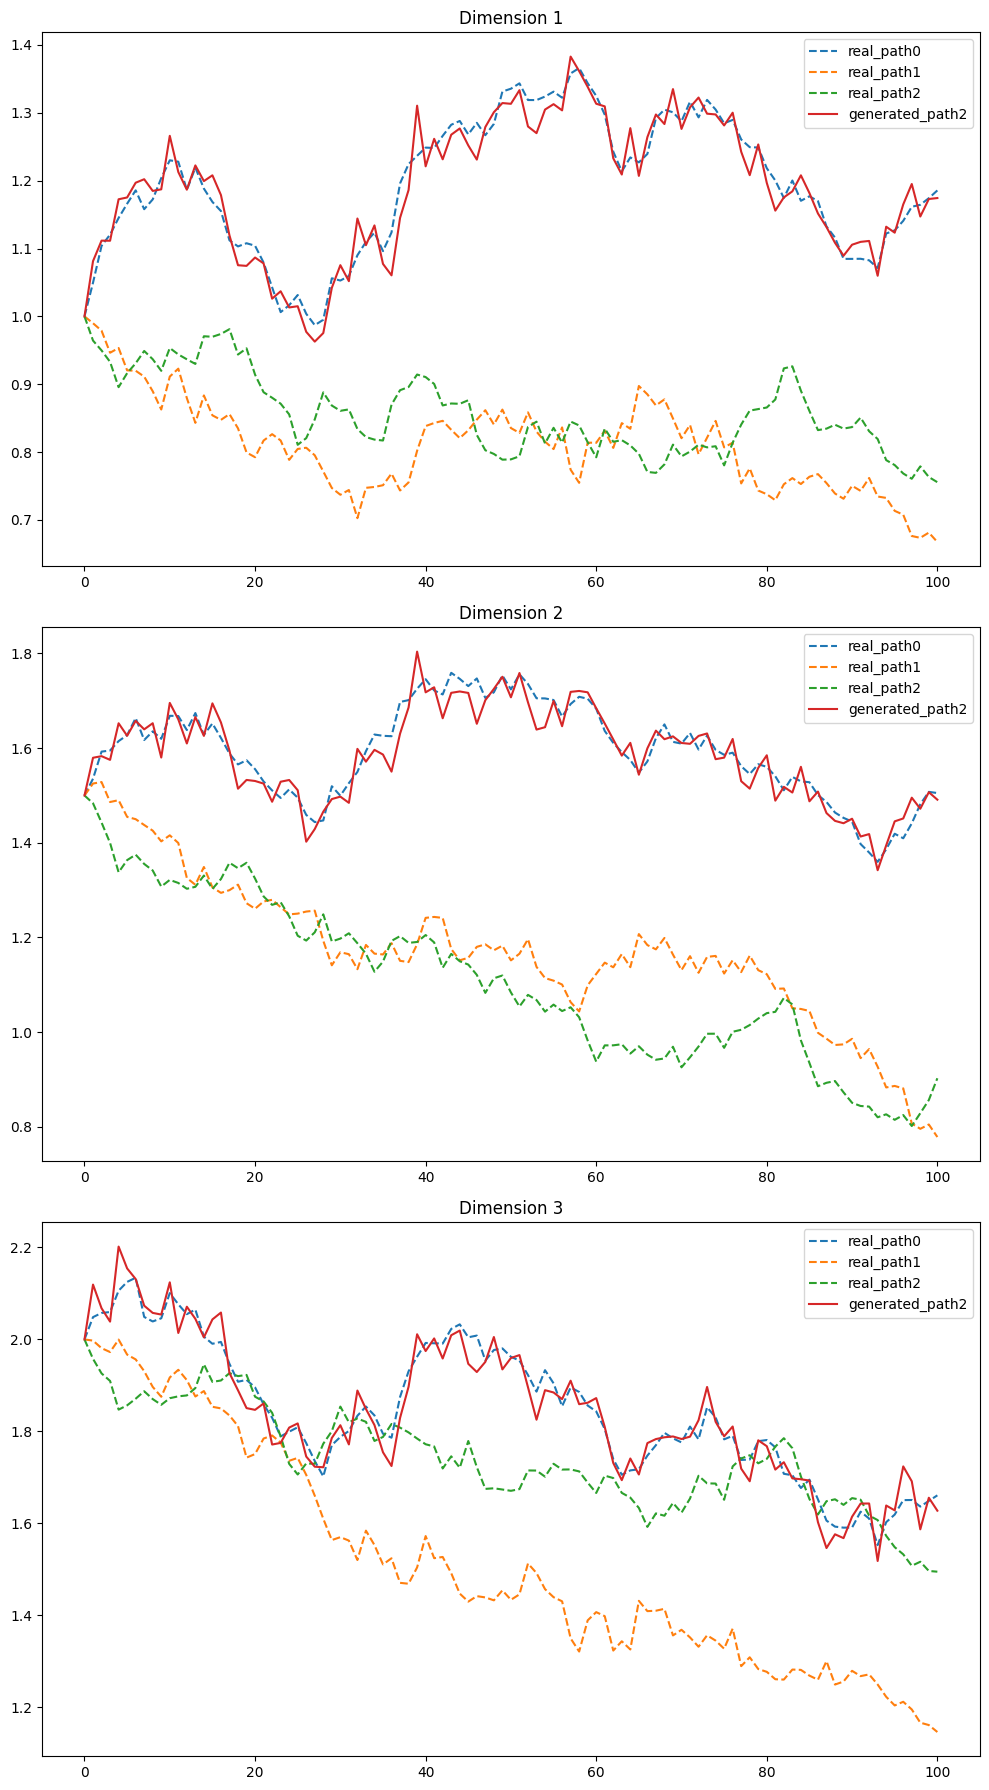

In [22]:
# Plotting each dimension separately
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

for i in range(3):
    real_path =  mu_data[:,i,:].T
    generated_path = X[:,i]

    for j in range(3):
        axs[i].plot(real_path[:,j], label=f'real_path{j}', linestyle="--")

    axs[i].plot(generated_path.unsqueeze(1).detach().numpy(), label=f'generated_path{j}')
    axs[i].legend()
    axs[i].set_title(f'Dimension {i+1}')

plt.tight_layout()
plt.show()

In [ ]:
model_mu.get_pred1(times, time_ptr, X, obs_idx, delta_t, T, start_X, n_obs_ot)

In [ ]:
mu_data[0,:,:10]

In [ ]:
mu_hat

In [ ]:
sigma_hat

In [ ]:
sigma_pred

In [ ]:
sigma_pred.reshape(3,3)

In [ ]:
vol_tensor

In [ ]:
Y=sigma_pred.reshape(3,3)

In [ ]:
start_vol = torch.tensor(vol_data[0,:,0], dtype=torch.float).unsqueeze(0)

In [ ]:
start_vol

In [ ]:
start_vol.reshape(3,3)

In [ ]:
Z=start_vol.reshape(3,3)

In [ ]:
Y.T@Y

In [ ]:
(Y.T@Y).view(1,-1)

In [ ]:
torch.sum(((Y.T@Y).view(1,-1) - start_vol)**2)

In [ ]:
times=np.array([])
time_ptr = np.array([0])
obs_idx = torch.tensor([],dtype=torch.long)
delta_t=0.01
T=1
Vol = torch.tensor([],dtype=torch.float)
X= torch.tensor(mu_data[0,:,0], dtype=torch.float).unsqueeze(0)
start_X = torch.tensor(mu_data[0,:,0], dtype=torch.float).unsqueeze(0)
n_obs_ot=torch.tensor([0], dtype=torch.float)
mu_hat = []
sigma_hat = []
for i in range(1,101):
    times=np.append(times, 0.01*i)
    time_ptr = np.append(time_ptr, i)
    obs_idx=torch.cat((obs_idx, torch.tensor([0], dtype=torch.long)))
    n_obs_ot+=1
    X= torch.cat((X, torch.tensor(mu_data[0,:,i], dtype=torch.float).unsqueeze(0)))
    mu_pred=model_mu.get_pred1(times, time_ptr, X, obs_idx, delta_t, T, start_X, n_obs_ot)["pred"][-1]
    X_t_plus = X[i,:].unsqueeze(0)
    X_t = X[i-1, :].unsqueeze(0)
    vol_tensor = (X_t_plus - X_t).T@(X_t_plus-X_t)
    vol  = vol_tensor.view(1,-1)
    Vol = torch.cat((Vol, vol))
    sigma_pred=model_vol.get_pred1(np.array([]), np.array([0]), Vol,torch.tensor([],dtype=torch.long), delta_t, T, vol, n_obs_ot=torch.tensor([0], dtype=torch.float))["pred"][-1]
    mu_t = (mu_pred - X_t)/delta_t
    sigma_t = sigma_pred/delta_t
    X_next = generate_next_value(X_t, mu_t, sigma_t.view(3,3), delta_t)
    X[i,:] = X_next
    mu_hat.append(mu_t)
    sigma_hat.append(sigma_t)

In [ ]:
X

In [ ]:
vol_data=np.load("../data/training_data/OrnsteinUhlenbeckForZ-44/data.npy")

In [ ]:
stock_paths_1, observed_dates_1, nb_obs_1, hyperparam_dict_1, obs_noise_1 = data_utils.load_dataset("OrnsteinUhlenbeckForZ", 44)
stock_paths_2, observed_dates_2, nb_obs_2, hyperparam_dict_2, obs_noise_2 = data_utils.load_dataset("OrnsteinUhlenbeckMultiDimensional", 46)

In [ ]:
delta_t=0.01
T=1

In [ ]:
def input_data(stock_paths, observed_dates, nb_obs, i):
    times = [0.01]
    time_ptr = [0, 1]
    obs_idx = []
    current_time = 0.
    counter = 0
    for t in range(1, observed_dates.shape[-1]):
        current_time += 0.01
        if observed_dates[0, t].sum() > 0:
            times.append(current_time)
            if observed_dates[0, t] == 1:
                counter += 1
                obs_idx.append(0)
        time_ptr.append(counter)
    obs_idx=torch.tensor(obs_idx, dtype=torch.long)
    X=torch.tensor(stock_paths[i,:,:].T, dtype=torch.float)
    start_X=torch.tensor(stock_paths[i,:,0], dtype=torch.float).reshape(1,stock_paths.shape[1])
    n_obs_ot=torch.tensor(nb_obs[i],dtype=torch.float).unsqueeze(0)
    return np.array(times), np.array(time_ptr), X, obs_idx, delta_t, T, start_X, n_obs_ot

In [ ]:
times, time_ptr, X, obs_idx, delta_t, T, start_X, n_obs_ot = input_data(stock_paths_1, observed_dates_1, nb_obs_1, 0)
vol_pred=model_vol.get_pred(times, time_ptr, X, obs_idx, delta_t, T, start_X,n_obs_ot)

In [ ]:
input_data=torch.tensor(vol_data[0,:,:].T, dtype=torch.float) 


In [ ]:
output_data=vol_pred["pred"].squeeze(1)

In [ ]:
input_data

In [ ]:
output_data

In [ ]:
times, time_ptr, X, obs_idx, delta_t, T, start_X, n_obs_ot = input_data(stock_paths_2, observed_dates_2, nb_obs_2, 0)
mu_pred=model_mu.get_pred(times, time_ptr, X, obs_idx, delta_t, T, start_X, n_obs_ot)["pred"]

In [ ]:
times=[]
time_ptr = [0]
obs_idx = torch.tensor([],dtype=torch.long)
delta_t=0.01
T=0.01
X= torch.tensor(mu_data[0,:,1], dtype=torch.float).reshape(1,3)
start_X = torch.tensor(mu_data[0,:,0], dtype=torch.float).reshape(1,3) 
Vol = torch.tensor(vol_data[0,:,0], dtype=torch.float).reshape(1,9)

start_vol = torch.tensor(vol_data[0,:,0], dtype=torch.float).reshape(1,9)
n_obs_ot=torch.tensor([0])
counts = 0
current_time=0
for i in range(2):
    mu=model_mu.get_pred(times, time_ptr, X, obs_idx, delta_t, T, start_X, n_obs_ot)["pred"][-1,:,:]
    mu_hat=(mu-start_X)/delta_t
    print(mu_hat)
    sigma_hat=model_vol.get_pred(times, time_ptr, Vol, obs_idx, delta_t, T, start_vol, n_obs_ot)["pred"][-1,:,:]
    print(sigma_hat)
    #X_next=generate_next_value(X[-1,:].reshape(1,3),mu_hat,vol_pred[2*i,:,:].reshape(3,3),delta_t)
    #Vol_next = (( X_next - X[-1,:]).T@( X_next - X[-1,:])).reshape(1,9)
    current_time+=delta_t
    T+=delta_t
    times=np.append(times,current_time)
    time_ptr=np.append(time_ptr, len(obs_idx)+1)
    obs_idx=torch.cat((obs_idx, torch.arange(start_X.shape[0], dtype=torch.long)))
    #X=torch.cat((X,X_next))
    #Vol=torch.cat((Vol, Vol_next))
    n_obs_ot+=1

In [ ]:
times=[]
time_ptr = [0]
obs_idx = torch.tensor([],dtype=torch.long)
delta_t=0.01
T=0.01
X= torch.tensor([[1.0], [1.5], [2.0]]).reshape(1,3)
start_X = torch.tensor([[1.0], [1.5], [2.0]]).reshape(1,3)
Vol = torch.tensor(vol_data[0,:,0], dtype=torch.float).unsqueeze(0)
start_vol = torch.tensor(vol_data[0,:,0], dtype=torch.float).unsqueeze(0)
n_obs_ot=torch.tensor([0])
counts = 0
current_time=0
for i in range(100):
    mu=model_mu.get_pred(times, time_ptr, X, obs_idx, delta_t, T, start_X, n_obs_ot)["pred"][-1,:,:] 
    mu_hat = (mu - X[-1,:].reshape(1,3))/delta_t 
    X_next=generate_next_value(X[-1,:].reshape(1,3),mu_hat,vol_pred[i,:,:].reshape(3,3),delta_t)
    Vol_next = (( X_next - X[-1,:]).T@( X_next - X[-1,:])).reshape(1,9)
    current_time+=delta_t
    T+=delta_t
    times=np.append(times,current_time)
    time_ptr=np.append(time_ptr, len(obs_idx)+1)
    obs_idx=torch.cat((obs_idx, torch.arange(start_X.shape[0], dtype=torch.long)))
    X=torch.cat((X,X_next)) 
    Vol=torch.cat((Vol, Vol_next))
    n_obs_ot+=1

In [ ]:
stock_paths_1, observed_dates_1, nb_obs_1, hyperparam_dict_1, obs_noise_1 = data_utils.load_dataset("OrnsteinUhlenbeckForZ", 45)
stock_paths_2, observed_dates_2, nb_obs_2, hyperparam_dict_2, obs_noise_2 = data_utils.load_dataset("OrnsteinUhlenbeckMultiDimensional", 46)

In [ ]:
def input_data(stock_paths, observed_dates, nb_obs, i):
    times = []
    time_ptr = [0]
    obs_idx = []
    current_time = 0.
    counter = 0
    for t in range(1, observed_dates.shape[-1]):
        current_time += 0.01
        if observed_dates[0, t].sum() > 0:
            times.append(current_time)
            if observed_dates[0, t] == 1:
                counter += 1
                obs_idx.append(0)
        time_ptr.append(counter) 
    obs_idx=torch.tensor(obs_idx, dtype=torch.long)
    X=torch.tensor(stock_paths[i,:,:].T, dtype=torch.float)
    start_X=torch.tensor(stock_paths[i,:,0], dtype=torch.float).reshape(1,stock_paths.shape[1])
    n_obs_ot=torch.tensor(nb_obs[i],dtype=torch.float).unsqueeze(0) 
    return np.array(times), np.array(time_ptr), X, obs_idx, delta_t, T, start_X, n_obs_ot

In [ ]:
def get_mu_hat(mu_pred, X, delta_t):
    mu_pred=mu_pred.squeeze(1)
    return (mu_pred-X)/delta_t

In [ ]:
def generate_path(X, mu_hat, vol_pred):
    X_generated = X[0,:].unsqueeze(0)
    for i in range(100):
        if i==0:
            X_next=generate_next_value(X[i,:],mu_hat[i,:].view(1,3),vol_pred[i,:,:].view(3,3),0.01)
        else:
            X_next=generate_next_value(X_next,mu_hat[i,:].view(1,3),vol_pred[i,:,:].view(3,3),0.01)
        X_generated=torch.cat((X_generated,X_next))
    return X_generated 

In [ ]:
from scipy.stats import linregress
def estimate_ou_parameters(paths, delta_t):
    """
    Estimate the parameters of an OU process from given paths.
    
    Parameters:
    - paths: numpy array of shape (num_paths, num_timesteps)
    - delta_t: time increment between observations
    
    Returns:
    - theta: rate of mean reversion
    - mu: long-term mean
    - sigma: volatility
    """
    num_paths, num_timesteps = paths.shape
         


    X_t = paths[:, :-1].flatten()
    X_t_plus_1 = paths[:, 1:].flatten()

    b, a, _, _, _ = linregress(X_t,X_t_plus_1)

    kappa_OLS = -np.log(b)/delta_t
    theta_OLS = a/(1-b)

    res=X_t_plus_1-b*X_t-a
    std_resid =np.std(res, ddof=2)

    sig_OLS = std_resid*np.sqrt(2*kappa_OLS/(1-b**2))

    return np.mean(kappa_OLS), np.mean(theta_OLS), np.mean(sig_OLS) 

"""
    X_t = paths[:, :-1]
    X_t_plus_1 = paths[:, 1:] 
    
    beta = np.empty(num_paths)
    alpha = np.empty(num_paths)
    kappa_OLS = np.empty(num_paths)
    theta_OLS = np.empty(num_paths)
    sig_OLS = np.empty(num_paths)
    
    for i in range(num_paths):
        b, a, _, _, _ = linregress(X_t[i],X_t_plus_1[i])
        beta[i] = b
        alpha[i] = a 
        
        kappa_OLS[i] = -np.log(b)/delta_t
        theta_OLS[i] = a/(1-b)
    
        res=X_t_plus_1[i]-b*X_t[i]-a
        std_resid =np.std(res, ddof=2)
    
        sig_OLS[i] = std_resid*np.sqrt(2*kappa_OLS[i]/(1-b**2))

    return np.mean(theta_OLS), np.mean(kappa_OLS), np.mean(sig_OLS)
""" 

In [ ]:
delta_t=0.01
T=1

In [ ]:
generated_paths=[]
for i in range(20):
    times, time_ptr, X, obs_idx, delta_t, T, start_X, n_obs_ot = input_data(stock_paths_1, observed_dates_1, nb_obs_1, i)
    vol_pred=model_vol.get_pred(times, time_ptr, X, obs_idx, delta_t, T, start_X,n_obs_ot)["pred"]
    times, time_ptr, X, obs_idx, delta_t, T, start_X, n_obs_ot = input_data(stock_paths_2, observed_dates_2, nb_obs_2, i)
    mu_pred=model_mu.get_pred(times, time_ptr, X, obs_idx, delta_t, T, start_X, n_obs_ot)["pred"]
    mu_hat=get_mu_hat(mu_pred,X,delta_t)
    generated_paths.append(generate_path(X,mu_hat,vol_pred))
    
generated_paths=torch.stack(generated_paths)    

In [ ]:
real_paths=[]
for i in range(10000):
    real_paths.append(torch.tensor(mu_data[i,:,:].T,dtype=torch.float)  )
real_paths=torch.stack(real_paths)

In [ ]:
for i in range(3):
    speed_1, mean_1, volatility_1 = estimate_ou_parameters(real_paths[:,:,i].detach().numpy(),0.01)
    speed_2, mean_2, volatility_2 = estimate_ou_parameters(generated_paths[:,:,i].detach().numpy(),0.01)
    print( f"Dimension {i+1}" )
    print( f" Data parameters: speed = {speed_1:.3f}, mean = {mean_1:.3f}, volatility = {volatility_1:.3f}"  )
    print( f" Generated data parameters: speed = {speed_2:.3f}, mean = {mean_2:.3f}, volatility = {volatility_2:.3f}"  )

In [ ]:
real_path = real_paths[:,:,0].T
generated_path = generated_paths[:,:,0].T

plt.figure(figsize=(10, 6))
for i in range(10):
    plt.plot(real_path[:,i], label=f'real_path{i}', linestyle="--")

plt.plot(generated_path.unsqueeze(1).detach().numpy(), label='generated_path')
plt.legend()
plt.show() 